In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [169]:
import numpy as np
from poly_matrix import polynomial, create_poly_matrix
from sb3_env import sb3_CityEnv  # make sure the env class is renamed properly if needed
from stable_baselines3 import PPO
import gymnasium as gym
from stable_baselines3.common.env_util import make_vec_env

# Environment parameters
N = 30
T = 24
poly_matrix = create_poly_matrix(N, T)
benchmark_size = 10
destination_set = [np.random.choice([0, 1], size=N) for i in range(benchmark_size)]
savefile_name = 'N10_testrun'

def make_env():
    return sb3_CityEnv(poly_matrix=poly_matrix, N=N, time_horizon=T)

env = make_vec_env(make_env, n_envs=50)


In [167]:

def eval_func(model):
    eval_env = sb3_CityEnv(poly_matrix=poly_matrix, N=N, time_horizon=T)
    start_time = 0.0
    start_vertex = 4
    total_time = 0
    episode_rewards = []
    for _ in range(benchmark_size):
        custom_reset_options = {
        "destinations": destination_set[_].copy(),
        "start_time": start_time,
        "start_vertex": start_vertex}
        obs, _ = eval_env.reset(options=custom_reset_options or {})
        done = False
        truncated = False
        total_reward = 0.0

        while not (done or truncated):
            #print(obs)
            action, _ = model.predict(obs, deterministic=True)
            #print(action)
            obs, reward, done, truncated, _ = eval_env.step(action)
            
            total_reward += reward
        total_time += eval_env.current_time
        episode_rewards.append(total_reward)

        avg_reward = np.mean(episode_rewards)
        std_reward = np.std(episode_rewards)

    return total_time

In [ ]:

model = PPO("MlpPolicy", env, verbose=0)
# Save and reload model
model.save(savefile_name)
example_travel_times = []
for i in range(50):
    print(i)
    # Load the model (optional)
    #env = sb3_CityEnv(poly_matrix=poly_matrix, N=N, time_horizon=T)
    model = PPO.load(savefile_name, env = env)
    
    model.learn(total_timesteps=100_000)
    time = eval_func(model)
    print(time)
    example_travel_times.append(time)
    model.save(savefile_name)
    


0
31.60668225492924
1
26.487913723456085
2
22.566937262124444
3
26.01086174409305
4
18.539624097356356
5
18.771898614781595
6
16.065052187541045
7
16.654701604696154
8
15.078435475029726
9
14.771825455512998
10
14.1383055565508
11
13.662264335250637
12
13.468216476013959
13
12.038359516613822
14
11.974032900418747
15
12.034822968587054
16
11.764110026178042
17
11.157522854902085
18


KeyboardInterrupt: 

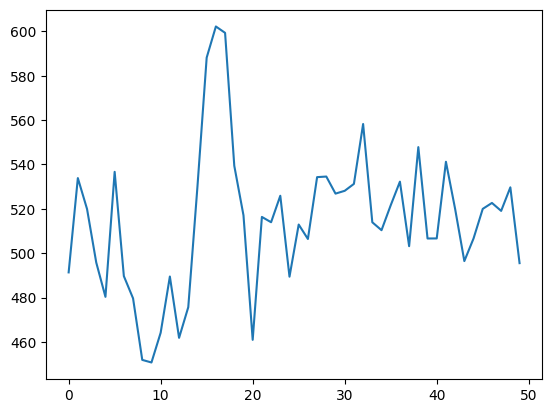

In [144]:
import matplotlib.pyplot as plt
plt.plot(example_travel_times)
plt.show()

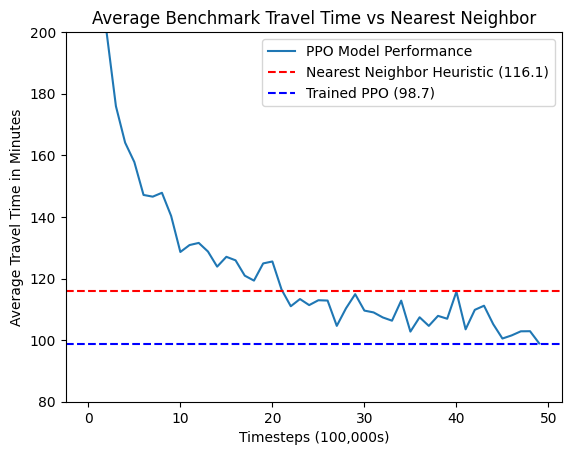

In [133]:
import matplotlib.pyplot as plt

# Plot the example travel times
plt.plot(60 * np.array(example_travel_times) / 100, label="PPO Model Performance")

# Add a red horizontal line at y=193.5
plt.axhline(y=193.5 * 60 / 100, color='red', linestyle='--', label=f"Nearest Neighbor Heuristic ({193.5 * 60 / 100})")
plt.axhline(y=164.5 * 60 / 100, color='blue', linestyle='--', label=f"Trained PPO ({164.5 * 60 / 100})")
# Add labels, title, and legend
plt.xlabel("Timesteps (100,000s)")
plt.ylabel("Average Travel Time in Minutes")
plt.title("Average Benchmark Travel Time vs Nearest Neighbor")
plt.legend()
plt.ylim(80, 200)
# Show the plot
plt.show()

In [123]:
import pickle
with open("example_travel_times.pkl", "wb") as f:
    pickle.dump(example_travel_times, f)

In [126]:
with open("destinations_set.pkl", "wb") as f:
    pickle.dump(destination_set, f)

In [136]:
with open("poly_matrix.pkl", "wb") as f:
    pickle.dump(poly_matrix, f)

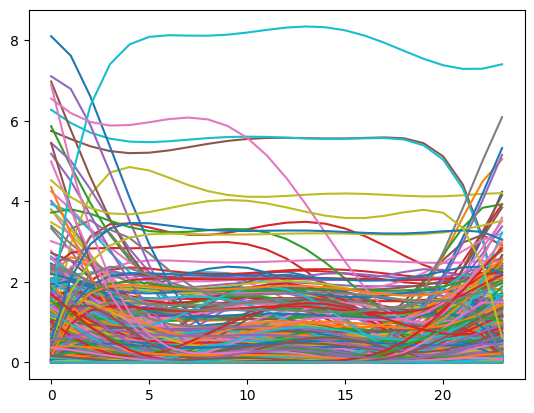

In [85]:
visualize_poly_matrix(poly_matrix)

In [140]:

def nearest_neighbors_with_time(travel_tensor, start_node, visit_nodes):
    visit_nodes = visit_nodes.copy()
    path = [start_node]
    current_node = start_node
    current_time = 0
    total_time = 0

    while len(visit_nodes) > 0:
        best_node = None
        best_time = float('inf')
        for node in visit_nodes:
            time_index = min(int(current_time), travel_tensor.shape[2] - 1)
            travel_time = travel_tensor[current_node, node, time_index]
            if travel_time < best_time:
                best_time = travel_time
                best_node = node

        if best_node is None:
            break

        # Update current state
        visit_nodes.remove(best_node)
        current_time += best_time
        total_time += best_time
        path.append(best_node)
        current_node = best_node

    return path, total_time

discretization_constant = 1000
def discretize_poly_matrix(poly_matrix, N):
    """
    Discretizes the polynomial travel times into a 3D numpy tensor of shape (N, N, T),
    where each entry [i, j, t] is the travel time from node i to j at time t.
    """
    tensor = np.zeros((N, N, discretization_constant), dtype=np.float32)
    for i in range(N):
        for j in range(N):
            for k in range(discretization_constant):
                t = k * 0.024
                tensor[i, j, k] = poly_matrix[i, j].eval(t)
    return tensor


def evaluate_policy(policy, poly_matrix, env_test, destinations, seed=50):
    
    obs, _ = env_test.reset(destinations=destinations.copy(), start_time=0, start_vertex=1)
    

    done = False
    total_reward = 0
    actions = []
    for i in range(env_test.max_steps):
        
        action = policy[i] 
        actions.append(action)
        obs, reward, done, _, _ = env_test.step(action)
    
        total_reward += reward
        if done:
            break
    print(actions)
    return total_reward

In [142]:
travel_tensor = discretize_poly_matrix(poly_matrix, N)
total_time = 0
for destinations in destination_set:
  visit_nodes = np.where(destinations == 1)[0]
  visit_nodes = visit_nodes.tolist()
  print(visit_nodes)
  start_node = 0
  path, travel_time = nearest_neighbors_with_time(travel_tensor, start_node, visit_nodes)
  total_time += travel_time
print(total_time)


[3, 4, 7, 9, 11, 12, 15, 17, 19, 21, 22, 25, 26, 29]
[1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 14, 15, 17, 19, 21, 22, 24, 29]
[1, 2, 3, 4, 5, 6, 10, 11, 12, 15, 17, 20, 21, 22, 23, 24, 25, 27, 28]
[2, 4, 5, 6, 7, 9, 10, 12, 14, 17, 19, 21, 22, 23, 24, 26, 29]
[0, 2, 5, 6, 7, 10, 13, 14, 15, 18, 19, 20, 21, 24, 25]
[1, 3, 4, 5, 7, 8, 9, 10, 14, 17, 18, 19, 22, 23, 26, 28]
[0, 2, 3, 5, 10, 11, 12, 13, 15, 20, 21, 24, 25, 26, 27]
[1, 2, 3, 5, 7, 10, 12, 13, 20, 22, 26, 28]
[2, 3, 4, 5, 6, 11, 12, 13, 15, 17, 19, 23, 29]
[1, 3, 6, 11, 12, 14, 16, 17, 22, 23, 28, 29]
[1, 2, 4, 8, 11, 12, 13, 14, 16, 17, 25, 27, 28, 29]
[1, 2, 5, 6, 7, 9, 13, 17, 20, 22, 23, 25, 26, 27, 29]
[1, 2, 3, 4, 9, 10, 11, 16, 22, 24, 25, 29]
[1, 4, 5, 6, 8, 12, 13, 15, 16, 17, 18, 19, 20, 21, 26, 27]
[0, 3, 7, 8, 11, 13, 14, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29]
[1, 2, 3, 5, 8, 9, 11, 14, 15, 16, 17, 20, 21, 22, 27]
[0, 1, 2, 3, 4, 7, 8, 12, 16, 17, 23, 24, 26, 27, 28]
[0, 4, 7, 9, 10, 14, 20, 22, 27, 28, 29]
[0, 

In [137]:
destination_set

[array([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]),
 array([1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0]),
 array([1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]),
 array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
 array([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]),
 array([1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]),
 array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0]),
 array([1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1]),
 array([1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1]),
 array([0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0]),
 array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1]),
 array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]),
 array([1, 1, 0, 1, 

0.6531967938604647


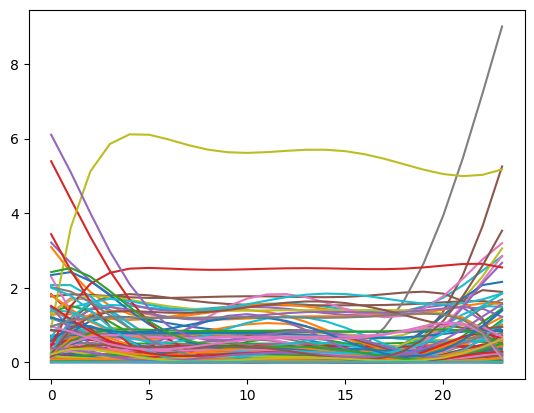

In [ ]:


from poly_matrix import polynomial, create_poly_matrix
N = 10
T = 24
count = 0
poly_matrix = create_poly_matrix(N, T)
for i in range(N):
  for j in range(N):
    vals = [poly_matrix[i][j].eval(t) for t in range(T)]
    count += sum(vals)
    plt.plot(vals, label=f"poly_matrix[{i}][{j}]")
print(count / ((N**2 - N) * 24))


Using device: cpu


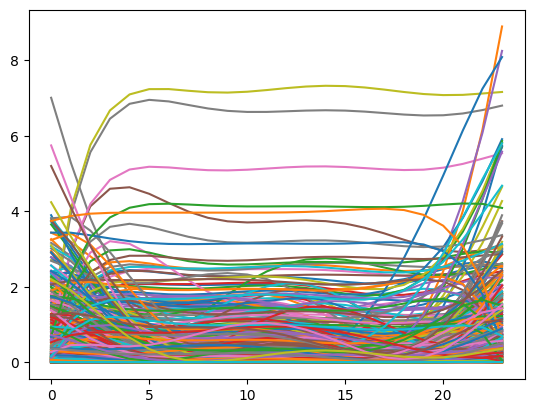

Max Steps:  500
Initial Destinations:  [1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 0 1]
tensor(0.3210, grad_fn=<NegBackward0>) tensor(1.1293, grad_fn=<DivBackward0>) tensor(2.9399, grad_fn=<MeanBackward0>)
Episode 0 | Total Reward: -2096.60 | Loss: 0.3029
Took 6371 Steps
Model saved at episode 0
tensor(0.3223, grad_fn=<NegBackward0>) tensor(1.1335, grad_fn=<DivBackward0>) tensor(2.9397, grad_fn=<MeanBackward0>)
Episode 1 | Total Reward: -1759.13 | Loss: 0.3042
Took 6099 Steps
tensor(0.3074, grad_fn=<NegBackward0>) tensor(1.1445, grad_fn=<DivBackward0>) tensor(2.9401, grad_fn=<MeanBackward0>)
Episode 2 | Total Reward: -1930.47 | Loss: 0.2894
Took 6396 Steps
tensor(0.3159, grad_fn=<NegBackward0>) tensor(1.1494, grad_fn=<DivBackward0>) tensor(2.9412, grad_fn=<MeanBackward0>)
Episode 3 | Total Reward: -1610.30 | Loss: 0.2980
Took 6103 Steps
tensor(0.3138, grad_fn=<NegBackward0>) tensor(1.1831, grad_fn=<DivBackward0>) tensor(2.9405, grad_fn=<MeanBackward0>)
Episode 4 | Total Reward: -1600.15 | Los

KeyboardInterrupt: 

In [2]:
# 🧠 PPO Training for TrafficEnv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np
import torch.nn.functional as F
from new_model import TravelNet
from poly_matrix import polynomial, create_poly_matrix
from new_env import CityEnv
import matplotlib.pyplot as plt
import random

def visualize_poly_matrix(poly_matrix):
  for i in range(N):
    for j in range(N):
      vals = [poly_matrix[i][j].eval(t) for t in range(T)]
      plt.plot(vals, label=f"poly_matrix[{i}][{j}]")
  plt.show()

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate environment and model
N = 20
T = 24
poly_matrix = create_poly_matrix(N, T)
visualize_poly_matrix(poly_matrix)
env = CityEnv(poly_matrix=poly_matrix, N=N, time_horizon=T, max_steps = 500)
obs_space = env.observation_space
action_space = env.action_space

# Create model
model = TravelNet(N).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
clip_epsilon = 0.2
gamma = 0.99

# Training loop parameters
num_episodes = 100_000
max_steps = env.max_steps
print(f'Max Steps: ', max_steps)
episode_rewards = []
num_trajectories_per_episode = 100

# Reset environment with custom parameters
initial_destinations = random_binary_array = np.random.choice([0, 1], size=N)
print('Initial Destinations: ', initial_destinations)
start_time = 0
start_vertex = 2
epsilon = 0.05

def unpack_observation(obs):
    current_time = obs[0]
    destinations = obs[1]
    current_vertex = obs[2]
    current_vertex_onehot = F.one_hot(torch.tensor(current_vertex), num_classes=env.n_vertices).float().squeeze(0)
    return current_time, destinations, current_vertex_onehot

for episode in range(num_episodes):

    # print_state((traffic_tensor, next_paths), traffic_tensor.size(0))

    log_probs = []
    values = []
    rewards = []
    states = []
    actions = []

    total_reward = 0
    total_steps = 0
    for j in range(num_trajectories_per_episode):
        obs, _ = env.reset(destinations=initial_destinations, start_time=start_time, start_vertex=start_vertex)
        current_time, destinations, current_vertex_onehot = unpack_observation(obs)
        for step in range(max_steps):
            
            action_dist, state_value = model(current_vertex_onehot, destinations, current_time)
            if random.random() < epsilon:
                action = torch.randint(0, N, (1,))
            else:
                action = action_dist.sample()
            new_obs, reward, done, truncated, _ = env.step(action.item())
            current_time, destinations, current_vertex_onehot = unpack_observation(new_obs)
            #print(destinations)
            total_reward += reward
            #print(reward)

            states.append(new_obs)
            actions.append(action)
            log_probs.append(action_dist.log_prob(action))
            values.append(state_value.squeeze())
            rewards.append(torch.tensor([reward], dtype=torch.float32, device=device))
            total_steps += 1
            if done:
                break

    # Compute returns and advantages
    returns = []
    G = 0
    #print(actions)
    #print(rewards)
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    returns = torch.cat(returns).detach()
    values = torch.stack(values).detach()
    log_probs = torch.stack(log_probs)
    actions = torch.stack(actions)

    advantages = (returns - values).detach()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    # PPO loss
    new_log_probs = []
    new_values = []

    for i, state in enumerate(states):
        current_time, destinations, current_vertex_onehot = unpack_observation(state)
        dist, value = model(current_vertex_onehot, destinations, current_time)
        new_log_probs.append(dist.log_prob(actions[i]))
        new_values.append(value.squeeze())

    new_log_probs = torch.stack(new_log_probs)
    new_values = torch.stack(new_values)

    ratio = (new_log_probs - log_probs.detach()).exp()
    surr1 = ratio * advantages
    surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantages
    policy_loss = -torch.min(surr1, surr2).mean()
    value_loss = (returns - new_values).pow(2).mean() / returns.mean().pow(2)
    entropy = dist.entropy().mean()
    print(policy_loss, value_loss, entropy)
    
    loss = policy_loss + 0.01 * value_loss - 0.01 * entropy  # Add entropy bonus

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)  # Gradient clipping
    optimizer.step()

    print(f"Episode {episode} | Total Reward: {total_reward:.2f} | Loss: {loss.item():.4f}")
    print(f'Took {total_steps} Steps')
    episode_rewards.append(total_reward)

    # save the model
    if episode % 100 == 0:
        torch.save(model.state_dict(), f"ppo_city_env_{episode}.pth")
        print(f"Model saved at episode {episode}")
    


In [19]:
len(episode_rewards)

3027

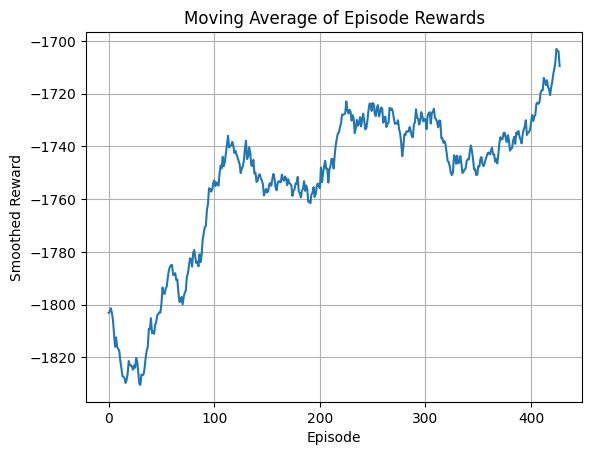

In [5]:
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Assuming `episode_rewards` is a list of raw reward values
smoothed_rewards = moving_average(episode_rewards)

plt.plot(smoothed_rewards)
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.title("Moving Average of Episode Rewards")
plt.grid(True)
plt.show()


In [31]:
float('-inf') * 0

nan